# Training the Algorithmic Traders

This notebook contains the code for generating and training the LSTM traders. We will be using the keras structures that are available with tensorflow as the basis for the struture.

In [34]:
import numpy as np #Import relevant packages
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import glob
import csv
import matplotlib.pyplot as plt

In [35]:
def unpack_data(filepath): #Returns a dictionary where each item is a df containing one run. One dict per generation.
    all_files = glob.glob(filepath + "/*.csv")
#    print(all_files)
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[77:-4])
#        print(name_list)
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
    for k, v in datadict.items():
        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
#        v.reset_index(drop=True)
#        v.index.name = "period"
    return datadict

In [36]:
gen0 = unpack_data("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen0_sims/data") #Load gen0 data

In [47]:
def format_data(datadict, window): #Turn dictionaries of data into features and samples lists
    x_data = []
    y_data = []
    for k, v in datadict.items():
        for i in range(len(v)):
            if i >= window:
                y_data.append(v.iloc[i]["trading_price"])
                xi = v.iloc[i-window:i].to_numpy()
                x_data.append(xi)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    y_data = np.reshape(y_data, (y_data.shape[0], 1))
    return x_data, y_data

In [48]:
X, y = format_data(gen0, 10)
print(X.shape)
print(y.shape)

(32360, 10, 2)
(32360, 1)


In [54]:
def normalise_data(xarray, yarray): #Take the natural log and then normalise prices
    yarray_log = np.log(yarray)
    xarray_log = np.log(xarray)
    xsc = StandardScaler()
    instances, timesteps, features = xarray_log.shape
    xarray_log = np.reshape(xarray_log, (-1, features))
    xarray_norm = xsc.fit_transform(xarray_log)
    xarray_norm = np.reshape(xarray_norm, (instances, timesteps, features))
    ysc = StandardScaler().fit(yarray_log)
    yarray_norm = ysc.transform(yarray_log)
    return xarray_norm, yarray_norm, xsc, ysc

def split_data(xarray, yarray, trainratio): #Split the data into training and test sets
    train_len = int(len(xarray)*trainratio)
    test_len = len(xarray) - train_len
    x_train, y_train, x_test, y_test = xarray[:train_len], yarray[:train_len], xarray[train_len:], yarray[train_len:]
    return x_train, y_train, x_test, y_test

In [57]:
X_train, y_train, X_test, y_test = split_data(X, y, 0.6)
X_train, y_train, Xscale, yscale = normalise_data(X_train, y_train)
X_test, y_test, _, _ = normalise_data(X_test, y_test)

In [107]:
def scaler():
    return Xscale

print(Xscale.mean_)
print(Xscale.var_)
print(yscale.mean_)
print(yscale.var_)

[4.72072684 4.78073085]
[0.04046444 0.01431437]
[4.72363942]
[0.04226946]


In [93]:
### UNFINISHED, just messing around and trying to set it up while I was trying to figure out the feature engineering

lstm1=keras.Sequential() #Set up the architecture of the model

lstm1.add(layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm1.add(layers.Dropout(0.2))

lstm1.add(layers.LSTM(units=50, return_sequences=True))
lstm1.add(layers.Dropout(0.2))

lstm1.add(layers.LSTM(units=50, return_sequences=True))
lstm1.add(layers.Dropout(0.2))

lstm1.add(layers.LSTM(units=50))
lstm1.add(layers.Dropout(0.2))

lstm1.add(layers.Dense(units = 1))

In [94]:
lstm1.compile(optimizer = 'nadam', loss = 'mean_squared_error', metrics=["accuracy"]) #Compile and train the model

history = lstm1.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_split=0.1, shuffle=False)

Train on 17474 samples, validate on 1942 samples
Epoch 1/100
17474/17474 [==============================] - 103s 6ms/sample - loss: 0.0744 - accuracy: 0.0000e+00 - val_loss: 0.0319 - val_accuracy: 0.0000e+00
Epoch 2/100
17474/17474 [==============================] - 81s 5ms/sample - loss: 0.0469 - accuracy: 0.0000e+00 - val_loss: 0.1552 - val_accuracy: 0.0000e+00
Epoch 3/100
17474/17474 [==============================] - 91s 5ms/sample - loss: 0.0321 - accuracy: 0.0000e+00 - val_loss: 0.0276 - val_accuracy: 0.0000e+00
Epoch 4/100
17474/17474 [==============================] - 76s 4ms/sample - loss: 0.0197 - accuracy: 0.0000e+00 - val_loss: 0.0517 - val_accuracy: 0.0000e+00
Epoch 5/100
17474/17474 [==============================] - 62s 4ms/sample - loss: 0.0223 - accuracy: 0.0000e+00 - val_loss: 0.1143 - val_accuracy: 0.0000e+00
Epoch 6/100
17474/17474 [==============================] - 62s 4ms/sample - loss: 0.0189 - accuracy: 0.0000e+00 - val_loss: 0.0584 - val_accuracy: 0.0000e+00
Ep

17474/17474 [==============================] - 81s 5ms/sample - loss: 0.0110 - accuracy: 0.0000e+00 - val_loss: 0.0383 - val_accuracy: 0.0000e+00
Epoch 53/100
17474/17474 [==============================] - 66s 4ms/sample - loss: 0.0140 - accuracy: 0.0000e+00 - val_loss: 0.0461 - val_accuracy: 0.0000e+00
Epoch 54/100
17474/17474 [==============================] - 80s 5ms/sample - loss: 0.0156 - accuracy: 0.0000e+00 - val_loss: 0.0221 - val_accuracy: 0.0000e+00
Epoch 55/100
17474/17474 [==============================] - 59s 3ms/sample - loss: 0.0118 - accuracy: 0.0000e+00 - val_loss: 0.0305 - val_accuracy: 0.0000e+00
Epoch 56/100
17474/17474 [==============================] - 79s 5ms/sample - loss: 0.0144 - accuracy: 0.0000e+00 - val_loss: 0.0403 - val_accuracy: 0.0000e+00
Epoch 57/100
17474/17474 [==============================] - 70s 4ms/sample - loss: 0.0139 - accuracy: 0.0000e+00 - val_loss: 0.0574 - val_accuracy: 0.0000e+00
Epoch 58/100
17474/17474 [==============================] -

In [64]:
print(lstm1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10, 50)            10600     
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 50)            20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 50)            20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 50)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)               

<function matplotlib.pyplot.legend(*args, **kwargs)>

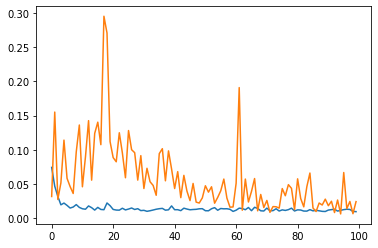

In [95]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend

In [96]:
y_pred = lstm1.predict(X_test)

In [97]:
y_train_inv = yscale.inverse_transform(y_train.reshape(1, -1))
y_test_inv = yscale.inverse_transform(y_test.reshape(1, -1))
y_pred_inv  = yscale.inverse_transform(y_pred)

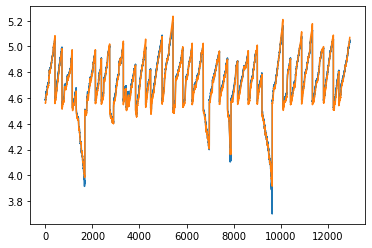

In [98]:
plt.plot(y_test_inv.flatten())
plt.plot(y_pred_inv.flatten())
plt.rcParams["figure.figsize"] = (18,6)

In [109]:
test1 = lstm1(X_train[0:1]).numpy()
test1 = yscale.inverse_transform(test1.reshape(1, -1))
test2 = float(test1)
test3 = math.exp(test2)
print(test3)
print(X_train[0:1])

93.81995229280146
[[[-0.57445791 -1.46737482]
  [-0.59787773 -1.45902077]
  [-0.61338546 -1.45067507]
  [-0.64152264 -1.44233769]
  [-0.65565117 -1.41322219]
  [-0.69827931 -1.40492207]
  [-0.72690251 -1.31908593]
  [-0.74744903 -1.3256575 ]
  [-0.76188229 -1.34128573]
  [-0.79762986 -1.3330567 ]]]


In [101]:
lstm1.save("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm1")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm1/assets
